In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import zipfile

plt.style.use("ggplot")

# settings
data_root = '/home/jma/Python3.7/Cubist_2021_11'

dtcol = 'data_date'
seccol = 'security_id'
numericcols = ['rf1', 'rf2', 'rf3', 'rf4', 'rf5', 'rf6']
start_date = '2010-07-01'

In [6]:
with zipfile.ZipFile(os.path.join(data_root, 'risk_factors.zip')) as zf:
    df = pd.read_csv(zf.open('risk_factors.csv'), parse_dates=[dtcol], 
                     dtype={seccol: str, 'rf1': np.float64, 'rf2': np.float64, 'rf3': np.float64, 
                            'rf4': np.float64, 'rf5': np.float64, 'rf6': np.float64})

In [7]:
assert not df.duplicated(subset=[dtcol, seccol]).any()
df[numericcols] = df[numericcols].apply(lambda x: pd.to_numeric(x, errors='coerce'))
print(df.dtypes)

data_date      datetime64[ns]
security_id            object
rf1                   float64
rf2                   float64
rf3                   float64
rf4                   float64
rf5                   float64
rf6                   float64
dtype: object


In [8]:
df[numericcols].describe().round(2)

rf1         rf2         rf3         rf4         rf5         rf6
count  8800015.00  8800015.00  8800015.00  8800015.00  8800015.00  8800015.00
mean         0.06       -0.29        0.57        0.47       -0.01       -0.50
std          1.17        1.16        1.27        1.20        1.11        1.29
min         -3.07       -3.17       -2.89       -2.82       -2.98       -3.39
25%         -0.72       -0.90       -0.46       -0.40       -0.69       -1.14
50%          0.06       -0.21        0.26        0.28       -0.06       -0.24
75%          0.84        0.37        1.59        1.22        0.60        0.26
max          3.70        2.95        3.03        3.28        2.98        2.79

In [10]:
rsch_universe = pd.read_csv(os.path.join(data_root, 'new_processed_csvs/new_known_df_on_data_date.csv.gz'),
                            parse_dates=['data_date', 'pos_date'], 
                            usecols=['data_date', 'pos_date', seccol, 'in_trading_universe',
                                     'clip_trisk', 'fwdret_f1', 'sector'], 
                            dtype={seccol: str})

In [11]:
rsch_universe = rsch_universe.loc[rsch_universe['in_trading_universe'] == 'Y']

In [12]:
df.isnull().sum()

data_date      0
security_id    0
rf1            0
rf2            0
rf3            0
rf4            0
rf5            0
rf6            0
dtype: int64

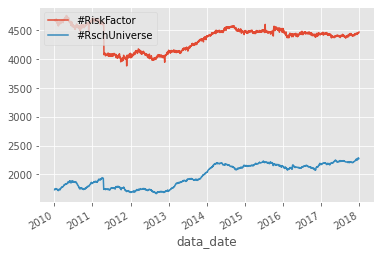

In [13]:
df.groupby('data_date').size().plot()
rsch_universe.groupby('data_date').size().plot()
plt.legend(['#RiskFactor', '#RschUniverse'], loc='upper left')

In [14]:
df = df.merge(rsch_universe)

In [15]:
df = df.loc[df['pos_date'] >= start_date]

In [16]:
def quickstats(df, scorecol, riskcol, riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id'):
    
    df = df.copy()
    
    
    ### get portfolio performance stats
    df['hld'] = df[scorecol] / np.power(df[riskcol], riskpower)
    df['hld_wgt'] =df.groupby(dtcol)['hld'].transform(lambda x: x / x.abs().sum())
    
    df['attr_fwdretf1'] = df['hld_wgt'] * df[retcol]
    xxx = df.groupby(dtcol, as_index=False)['attr_fwdretf1'].apply(lambda x: x.sum())
    xxx['year'] = xxx['pos_date'].dt.year
    
    ann_stats = xxx.groupby('year')['attr_fwdretf1'].apply(
        lambda x: pd.Series([x.mean() * 252, x.std() * np.sqrt(252), x.shape[0]],
                            index=['AnnRet', 'AnnVol', 'Days'])).unstack()
    ann_stats['AnnSR'] = ann_stats['AnnRet'] / ann_stats['AnnVol']
    
    ### 
    ncount = df.groupby(dtcol, as_index=False)[scorecol].size()
    ncount['year'] = ncount[dtcol].dt.year
    ncount = ncount.groupby('year').mean().astype(int)
    
    xxx.set_index(dtcol)['attr_fwdretf1'].cumsum().plot(title=f'score={scorecol}')
    return xxx.drop(['year'], axis=1), pd.concat([ann_stats.round(4), ncount], axis=1)

In [ ]:
daily_return1, return_stats1 = quickstats(df, 'rf1', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(return_stats1)
print(daily_return1.tail())

In [ ]:
daily_return2, return_stats2 = quickstats(df, 'rf2', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(return_stats2)
print(daily_return2.tail())

      AnnRet  AnnVol   Days   AnnSR  size
year                                     
2010 -0.1358  0.0583  128.0 -2.3284  1801
2011 -0.0669  0.0927  252.0 -0.7215  1793
2012 -0.0737  0.0411  250.0 -1.7949  1715
2013 -0.1017  0.0515  252.0 -1.9732  1886
2014 -0.0680  0.0443  252.0 -1.5340  2141
2015 -0.0129  0.0622  252.0 -0.2073  2178
2016 -0.1046  0.0646  252.0 -1.6198  2124
2017 -0.0485  0.0440  250.0 -1.1009  2216


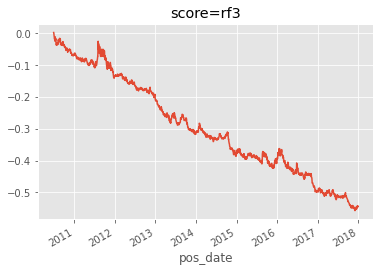

In [18]:
daily_return3, return_stats3 = quickstats(df, 'rf3', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(return_stats3)
# print(daily_return3.tail())

In [4]:
quickstats(df, 'rf3', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

NameError: name 'quickstats' is not defined

In [ ]:
quickstats(df, 'rf5', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

In [ ]:
quickstats(df, 'rf6', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

In [12]:
score9 = pd.read_csv(os.path.join(data_root, 'score9.csv.gz'), compression='gzip', parse_dates=['pos_date'], 
                    dtype={seccol: str})

In [13]:
print(score9.tail())
print(df.tail())

          pos_date security_id    score9
3406605 2017-12-22      968101  0.417167
3406606 2017-12-22       97801 -0.289091
3406607 2017-12-22      985601 -1.851753
3406608 2017-12-22      995201 -0.118611
3406609 2017-12-22      996501  0.914429
         data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6  \
3854033 2017-12-21  1117267201  0.534  1.776  2.334 -0.643  2.672 -0.693   
3854034 2017-12-21  1117291901  1.820  2.487  2.544 -0.618  2.672  0.704   
3854035 2017-12-21  1117267401 -1.150 -1.421  0.738  1.194  0.432 -0.378   
3854036 2017-12-21  1117382401 -1.333 -2.787  2.046 -0.383 -1.315 -1.364   
3854037 2017-12-21  1101172401 -0.185 -1.140 -0.358  1.963 -0.080 -0.839   

          pos_date  fwdret_f1 in_trading_universe                  sector  \
3854033 2017-12-22  -0.030287                   Y  Consumer Discretionary   
3854034 2017-12-22  -0.018989                   Y  Information Technology   
3854035 2017-12-22  -0.000676                   Y  Information Tec

In [14]:
df = df.merge(score9)

In [15]:
df.head()

data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6   pos_date  \
0 2010-06-30     2297301 -0.081 -0.476  0.561 -0.008  0.782  0.273 2010-07-01   
1 2010-06-30     4159901  0.901 -1.960  1.379  2.436  1.374 -3.080 2010-07-01   
2 2010-06-30     4914901  0.922 -0.234 -1.030  0.750 -0.011 -0.062 2010-07-01   
3 2010-06-30      599401  1.241  0.309 -1.230  1.205 -0.902  1.022 2010-07-01   
4 2010-06-30     5779301 -0.845 -0.151 -0.281  0.645 -0.086  0.069 2010-07-01   

   fwdret_f1 in_trading_universe                  sector  clip_trisk    score9  
0  -0.019348                   Y  Information Technology   32.179596 -1.381244  
1  -0.029506                   Y  Communication Services   54.947664  1.083304  
2  -0.008342                   Y              Financials   34.047535 -0.989049  
3   0.001081                   Y              Financials   41.323075 -0.908016  
4  -0.009769                   Y              Financials   26.430092  1.303674

<AxesSubplot:xlabel='pos_date'>

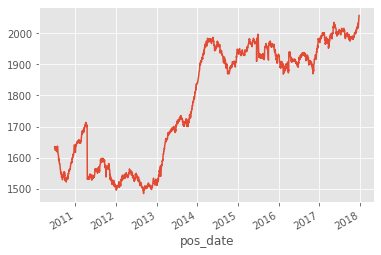

In [16]:
df.groupby("pos_date").size().plot()

In [17]:
df[numericcols + ['score9']].corr().round(4)

rf1     rf2     rf3     rf4     rf5     rf6  score9
rf1     1.0000  0.0041  0.0695  0.0270  0.0900 -0.1657 -0.0083
rf2     0.0041  1.0000 -0.0774 -0.3359  0.0460 -0.0847  0.1007
rf3     0.0695 -0.0774  1.0000 -0.1316  0.1945 -0.4032 -0.0355
rf4     0.0270 -0.3359 -0.1316  1.0000 -0.2799  0.3098 -0.0289
rf5     0.0900  0.0460  0.1945 -0.2799  1.0000 -0.0577 -0.0059
rf6    -0.1657 -0.0847 -0.4032  0.3098 -0.0577  1.0000 -0.0333
score9 -0.0083  0.1007 -0.0355 -0.0289 -0.0059 -0.0333  1.0000

In [18]:
df['flipped_rf3'] = -df['rf3']

In [ ]:
daily_return_flipped3, return_stats_flipped3 = \
    quickstats(df, 'flipped_rf3', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')
print(return_stats_flipped3)

In [ ]:
daily_return_score9, return_stats_score9 = \
    quickstats(df, 'score9', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

In [ ]:
df.head()

In [19]:
import statsmodels.api as sm

def orth_by_day(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    return results.resid, results.rsquared_adj

def orthogonalize(df, dep_col, ind_cols, fit_intercept=False, dtcol='pos_date'):
    
    df = df.copy()
    alldts = df[dtcol].unique()
    
    l = []
    
    for dt in alldts:
        dt = pd.Timestamp(dt)
        print(f"Processing date {dt}")
        y = df.loc[df[dtcol] == dt, dep_col].copy()
        X = df.loc[df[dtcol] == dt, ind_cols].copy()
#         print(X.head())
#         print(y.head())
        if fit_intercept:
            X = sm.add_constant(X)
        resid, rsquare_adj = orth_by_day(X, y)
        print(f"    Fitted square is {rsquare_adj}")
        l.append(resid)
    df['Resid'] = pd.concat(l)
    return df

In [20]:
df_residual = orthogonalize(df, 'score9', numericcols)

Processing date 2010-07-01 00:00:00
    Fitted square is 0.0076872908750637015
Processing date 2010-07-02 00:00:00
    Fitted square is 0.01322777356147331
Processing date 2010-07-08 00:00:00
    Fitted square is 0.014036391606356391
Processing date 2010-07-09 00:00:00
    Fitted square is 0.014684514303686447
Processing date 2010-07-12 00:00:00
    Fitted square is 0.012675545845843184
Processing date 2010-07-13 00:00:00
    Fitted square is 0.01218991149104609
Processing date 2010-07-14 00:00:00
    Fitted square is 0.010172731690398118
Processing date 2010-07-15 00:00:00
    Fitted square is 0.01376874268276096
Processing date 2010-07-16 00:00:00
    Fitted square is 0.013955877724076915
Processing date 2010-07-19 00:00:00
    Fitted square is 0.01282298304193219
Processing date 2010-07-20 00:00:00
    Fitted square is 0.013206152062479215
Processing date 2010-07-21 00:00:00
    Fitted square is 0.011886561654221084
Processing date 2010-07-22 00:00:00
    Fitted square is 0.01617662

    Fitted square is 0.00676827538942204
Processing date 2010-12-14 00:00:00
    Fitted square is 0.007552663331858445
Processing date 2010-12-15 00:00:00
    Fitted square is 0.007829911946976353
Processing date 2010-12-16 00:00:00
    Fitted square is 0.010254582684852798
Processing date 2010-12-17 00:00:00
    Fitted square is 0.007565946075577368
Processing date 2010-12-21 00:00:00
    Fitted square is 0.007307311898297253
Processing date 2010-12-22 00:00:00
    Fitted square is 0.00899654628637625
Processing date 2010-12-23 00:00:00
    Fitted square is 0.01050377841606509
Processing date 2010-12-27 00:00:00
    Fitted square is 0.012778306245289972
Processing date 2010-12-28 00:00:00
    Fitted square is 0.014728457463413558
Processing date 2010-12-31 00:00:00
    Fitted square is 0.016021826004728124
Processing date 2011-01-03 00:00:00
    Fitted square is 0.013512062706115602
Processing date 2011-01-04 00:00:00
    Fitted square is 0.015295086159012095
Processing date 2011-01-0

    Fitted square is 0.02241475169132634
Processing date 2011-05-23 00:00:00
    Fitted square is 0.018909091812542966
Processing date 2011-05-24 00:00:00
    Fitted square is 0.01899599928143214
Processing date 2011-05-25 00:00:00
    Fitted square is 0.018456125579431326
Processing date 2011-05-26 00:00:00
    Fitted square is 0.01583999329716612
Processing date 2011-05-27 00:00:00
    Fitted square is 0.020775153316154094
Processing date 2011-05-31 00:00:00
    Fitted square is 0.019737752564936484
Processing date 2011-06-01 00:00:00
    Fitted square is 0.018080548027799903
Processing date 2011-06-02 00:00:00
    Fitted square is 0.013229438188852916
Processing date 2011-06-03 00:00:00
    Fitted square is 0.012708550405834296
Processing date 2011-06-06 00:00:00
    Fitted square is 0.014440344310341025
Processing date 2011-06-07 00:00:00
    Fitted square is 0.012254199727790405
Processing date 2011-06-08 00:00:00
    Fitted square is 0.012953542491650816
Processing date 2011-06-0

    Fitted square is 0.007286849506344173
Processing date 2011-11-01 00:00:00
    Fitted square is 0.010642203314671694
Processing date 2011-11-02 00:00:00
    Fitted square is 0.00982049185729239
Processing date 2011-11-03 00:00:00
    Fitted square is 0.008303996468637775
Processing date 2011-11-04 00:00:00
    Fitted square is 0.0033377735150305066
Processing date 2011-11-07 00:00:00
    Fitted square is 0.007083503418100823
Processing date 2011-11-08 00:00:00
    Fitted square is 0.007456611627836396
Processing date 2011-11-09 00:00:00
    Fitted square is 0.006068775649990865
Processing date 2011-11-10 00:00:00
    Fitted square is 0.006560949585551534
Processing date 2011-11-11 00:00:00
    Fitted square is 0.004740595942499759
Processing date 2011-11-14 00:00:00
    Fitted square is 0.004015855731303253
Processing date 2011-11-15 00:00:00
    Fitted square is 0.003449319087730718
Processing date 2011-11-16 00:00:00
    Fitted square is 0.004214498299957126
Processing date 2011-1

    Fitted square is 0.02821111168036239
Processing date 2012-04-09 00:00:00
    Fitted square is 0.02626579555095876
Processing date 2012-04-10 00:00:00
    Fitted square is 0.02610023544378215
Processing date 2012-04-11 00:00:00
    Fitted square is 0.023105906651819996
Processing date 2012-04-12 00:00:00
    Fitted square is 0.02848946806120034
Processing date 2012-04-13 00:00:00
    Fitted square is 0.03452744075609582
Processing date 2012-04-16 00:00:00
    Fitted square is 0.027605453730718432
Processing date 2012-04-17 00:00:00
    Fitted square is 0.027880014008924592
Processing date 2012-04-18 00:00:00
    Fitted square is 0.030215539074062048
Processing date 2012-04-19 00:00:00
    Fitted square is 0.027748486417760176
Processing date 2012-04-20 00:00:00
    Fitted square is 0.024863367984368834
Processing date 2012-04-23 00:00:00
    Fitted square is 0.025190038038476636
Processing date 2012-04-24 00:00:00
    Fitted square is 0.023347761133531986
Processing date 2012-04-25 

    Fitted square is 0.015828333376366577
Processing date 2012-09-13 00:00:00
    Fitted square is 0.015760076745795493
Processing date 2012-09-14 00:00:00
    Fitted square is 0.018175837441092968
Processing date 2012-09-17 00:00:00
    Fitted square is 0.0167201689451979
Processing date 2012-09-19 00:00:00
    Fitted square is 0.015723805718442785
Processing date 2012-09-20 00:00:00
    Fitted square is 0.01953670438942301
Processing date 2012-09-21 00:00:00
    Fitted square is 0.023286221573011634
Processing date 2012-09-24 00:00:00
    Fitted square is 0.02314468792458635
Processing date 2012-09-25 00:00:00
    Fitted square is 0.02090121137646439
Processing date 2012-09-26 00:00:00
    Fitted square is 0.022429783099930267
Processing date 2012-09-27 00:00:00
    Fitted square is 0.022399946253728098
Processing date 2012-09-28 00:00:00
    Fitted square is 0.020023689063344396
Processing date 2012-10-01 00:00:00
    Fitted square is 0.024090323543073833
Processing date 2012-10-02 

    Fitted square is 0.014480782741582154
Processing date 2013-03-05 00:00:00
    Fitted square is 0.015690236460469076
Processing date 2013-03-06 00:00:00
    Fitted square is 0.018163784907130442
Processing date 2013-03-07 00:00:00
    Fitted square is 0.015172397340447397
Processing date 2013-03-08 00:00:00
    Fitted square is 0.016852910647639607
Processing date 2013-03-11 00:00:00
    Fitted square is 0.01428573866215932
Processing date 2013-03-12 00:00:00
    Fitted square is 0.015228182301009974
Processing date 2013-03-13 00:00:00
    Fitted square is 0.01470096046570557
Processing date 2013-03-14 00:00:00
    Fitted square is 0.013469397785683235
Processing date 2013-03-15 00:00:00
    Fitted square is 0.014567981142879827
Processing date 2013-03-18 00:00:00
    Fitted square is 0.01644685619515185
Processing date 2013-03-19 00:00:00
    Fitted square is 0.018856507112159027
Processing date 2013-03-20 00:00:00
    Fitted square is 0.015066281387720926
Processing date 2013-03-2

    Fitted square is 0.03347111901704547
Processing date 2013-08-06 00:00:00
    Fitted square is 0.03540358951626421
Processing date 2013-08-07 00:00:00
    Fitted square is 0.03029614419105897
Processing date 2013-08-08 00:00:00
    Fitted square is 0.03490310936723373
Processing date 2013-08-09 00:00:00
    Fitted square is 0.03180747246137805
Processing date 2013-08-12 00:00:00
    Fitted square is 0.03394481775971547
Processing date 2013-08-13 00:00:00
    Fitted square is 0.03118046089689397
Processing date 2013-08-14 00:00:00
    Fitted square is 0.029979442033942982
Processing date 2013-08-15 00:00:00
    Fitted square is 0.0295962798475784
Processing date 2013-08-16 00:00:00
    Fitted square is 0.038756370991471334
Processing date 2013-08-19 00:00:00
    Fitted square is 0.03833160619555176
Processing date 2013-08-20 00:00:00
    Fitted square is 0.03454082894617816
Processing date 2013-08-21 00:00:00
    Fitted square is 0.03538035676627782
Processing date 2013-08-22 00:00:0

    Fitted square is 0.0322121413830776
Processing date 2014-01-21 00:00:00
    Fitted square is 0.03364839636603345
Processing date 2014-01-22 00:00:00
    Fitted square is 0.031588479954124726
Processing date 2014-01-23 00:00:00
    Fitted square is 0.02856652094233947
Processing date 2014-01-24 00:00:00
    Fitted square is 0.028960458768522046
Processing date 2014-01-27 00:00:00
    Fitted square is 0.03093188190543872
Processing date 2014-01-28 00:00:00
    Fitted square is 0.034021062585144146
Processing date 2014-01-29 00:00:00
    Fitted square is 0.03316014511759802
Processing date 2014-01-30 00:00:00
    Fitted square is 0.03644658935013101
Processing date 2014-01-31 00:00:00
    Fitted square is 0.03766864000464676
Processing date 2014-02-03 00:00:00
    Fitted square is 0.03595445870204583
Processing date 2014-02-04 00:00:00
    Fitted square is 0.041442429505183176
Processing date 2014-02-05 00:00:00
    Fitted square is 0.04018399159942565
Processing date 2014-02-06 00:00

    Fitted square is 0.02132135482243669
Processing date 2014-06-25 00:00:00
    Fitted square is 0.0197205938567262
Processing date 2014-06-26 00:00:00
    Fitted square is 0.018289518617523814
Processing date 2014-06-27 00:00:00
    Fitted square is 0.02200742661424193
Processing date 2014-06-30 00:00:00
    Fitted square is 0.020850154926850162
Processing date 2014-07-01 00:00:00
    Fitted square is 0.02133897480959257
Processing date 2014-07-02 00:00:00
    Fitted square is 0.024707018685962367
Processing date 2014-07-03 00:00:00
    Fitted square is 0.023813259085518124
Processing date 2014-07-07 00:00:00
    Fitted square is 0.02293691963544875
Processing date 2014-07-08 00:00:00
    Fitted square is 0.022126202240400294
Processing date 2014-07-09 00:00:00
    Fitted square is 0.020739721905098762
Processing date 2014-07-10 00:00:00
    Fitted square is 0.02240379240177781
Processing date 2014-07-11 00:00:00
    Fitted square is 0.0220492146165151
Processing date 2014-07-14 00:0

    Fitted square is 0.011391733563276052
Processing date 2014-12-03 00:00:00
    Fitted square is 0.013450618540747805
Processing date 2014-12-04 00:00:00
    Fitted square is 0.013622748738996826
Processing date 2014-12-05 00:00:00
    Fitted square is 0.013374844655217433
Processing date 2014-12-08 00:00:00
    Fitted square is 0.014673566481478884
Processing date 2014-12-09 00:00:00
    Fitted square is 0.016990975934337293
Processing date 2014-12-10 00:00:00
    Fitted square is 0.017238752117864853
Processing date 2014-12-11 00:00:00
    Fitted square is 0.0116433504262633
Processing date 2014-12-12 00:00:00
    Fitted square is 0.013284536176050632
Processing date 2014-12-15 00:00:00
    Fitted square is 0.012280328491804826
Processing date 2014-12-16 00:00:00
    Fitted square is 0.012195021557681263
Processing date 2014-12-17 00:00:00
    Fitted square is 0.014907367282251616
Processing date 2014-12-18 00:00:00
    Fitted square is 0.012810155711669657
Processing date 2014-12-

    Fitted square is 0.012774795858861765
Processing date 2015-05-14 00:00:00
    Fitted square is 0.01186743703983606
Processing date 2015-05-15 00:00:00
    Fitted square is 0.012193837083330106
Processing date 2015-05-18 00:00:00
    Fitted square is 0.008658118925554792
Processing date 2015-05-19 00:00:00
    Fitted square is 0.00857325913285334
Processing date 2015-05-20 00:00:00
    Fitted square is 0.009058640721206324
Processing date 2015-05-21 00:00:00
    Fitted square is 0.0075865958969723035
Processing date 2015-05-22 00:00:00
    Fitted square is 0.0074146932792540365
Processing date 2015-05-26 00:00:00
    Fitted square is 0.009070580345051038
Processing date 2015-05-27 00:00:00
    Fitted square is 0.011876038422961144
Processing date 2015-05-28 00:00:00
    Fitted square is 0.013104362357135968
Processing date 2015-05-29 00:00:00
    Fitted square is 0.012558515112711555
Processing date 2015-06-01 00:00:00
    Fitted square is 0.01410209957642583
Processing date 2015-06

    Fitted square is 0.00299025966616262
Processing date 2015-10-22 00:00:00
    Fitted square is 0.002510102674677772
Processing date 2015-10-23 00:00:00
    Fitted square is 0.002067085147497205
Processing date 2015-10-26 00:00:00
    Fitted square is 0.00022646825454053499
Processing date 2015-10-27 00:00:00
    Fitted square is 0.00022256760560068756
Processing date 2015-10-28 00:00:00
    Fitted square is 0.0004336640735022046
Processing date 2015-10-29 00:00:00
    Fitted square is 0.001269932452442446
Processing date 2015-10-30 00:00:00
    Fitted square is 0.0010049313039068863
Processing date 2015-11-02 00:00:00
    Fitted square is 0.0008683023734755713
Processing date 2015-11-03 00:00:00
    Fitted square is 0.000293970469613658
Processing date 2015-11-04 00:00:00
    Fitted square is 0.00022573990196428362
Processing date 2015-11-05 00:00:00
    Fitted square is -0.0003536709774150104
Processing date 2015-11-06 00:00:00
    Fitted square is -3.7632777164287035e-05
Processin

    Fitted square is 0.007371125861385441
Processing date 2016-04-01 00:00:00
    Fitted square is 0.0061287838125214655
Processing date 2016-04-04 00:00:00
    Fitted square is 0.004024176838061111
Processing date 2016-04-05 00:00:00
    Fitted square is 0.008311759599148316
Processing date 2016-04-06 00:00:00
    Fitted square is 0.0072166277407930135
Processing date 2016-04-07 00:00:00
    Fitted square is 0.006722418523448348
Processing date 2016-04-08 00:00:00
    Fitted square is 0.006438869288837412
Processing date 2016-04-12 00:00:00
    Fitted square is 0.008144747466374835
Processing date 2016-04-13 00:00:00
    Fitted square is 0.007184342003072719
Processing date 2016-04-14 00:00:00
    Fitted square is 0.006826754928302314
Processing date 2016-04-15 00:00:00
    Fitted square is 0.006822134983422767
Processing date 2016-04-18 00:00:00
    Fitted square is 0.007094317142041229
Processing date 2016-04-19 00:00:00
    Fitted square is 0.010112755399340534
Processing date 2016

    Fitted square is 0.02258880387874662
Processing date 2016-09-08 00:00:00
    Fitted square is 0.022372972215341957
Processing date 2016-09-09 00:00:00
    Fitted square is 0.021478057422222196
Processing date 2016-09-12 00:00:00
    Fitted square is 0.018825122897760616
Processing date 2016-09-13 00:00:00
    Fitted square is 0.019835752197488787
Processing date 2016-09-14 00:00:00
    Fitted square is 0.019615081181833527
Processing date 2016-09-15 00:00:00
    Fitted square is 0.019545285707449067
Processing date 2016-09-16 00:00:00
    Fitted square is 0.021042674793610994
Processing date 2016-09-20 00:00:00
    Fitted square is 0.024714385574272524
Processing date 2016-09-21 00:00:00
    Fitted square is 0.02760394340007577
Processing date 2016-09-22 00:00:00
    Fitted square is 0.020067528064622864
Processing date 2016-09-23 00:00:00
    Fitted square is 0.022374082871638
Processing date 2016-09-26 00:00:00
    Fitted square is 0.021736528284177048
Processing date 2016-09-27 

    Fitted square is 0.03235432281715189
Processing date 2017-02-22 00:00:00
    Fitted square is 0.02745785931900091
Processing date 2017-02-23 00:00:00
    Fitted square is 0.02950174206494427
Processing date 2017-02-24 00:00:00
    Fitted square is 0.02607654611753829
Processing date 2017-02-27 00:00:00
    Fitted square is 0.028205551417930685
Processing date 2017-02-28 00:00:00
    Fitted square is 0.02904527956719205
Processing date 2017-03-01 00:00:00
    Fitted square is 0.026923081031617557
Processing date 2017-03-02 00:00:00
    Fitted square is 0.03017743233013037
Processing date 2017-03-03 00:00:00
    Fitted square is 0.029092615127849886
Processing date 2017-03-06 00:00:00
    Fitted square is 0.027670360651539272
Processing date 2017-03-07 00:00:00
    Fitted square is 0.02595371446844741
Processing date 2017-03-08 00:00:00
    Fitted square is 0.025768707922915635
Processing date 2017-03-09 00:00:00
    Fitted square is 0.02532111447613028
Processing date 2017-03-10 00:

    Fitted square is 0.024433684159846925
Processing date 2017-08-02 00:00:00
    Fitted square is 0.023806039069053098
Processing date 2017-08-03 00:00:00
    Fitted square is 0.02497046821258908
Processing date 2017-08-04 00:00:00
    Fitted square is 0.025832789941604983
Processing date 2017-08-07 00:00:00
    Fitted square is 0.024010294256001985
Processing date 2017-08-08 00:00:00
    Fitted square is 0.0227792623052
Processing date 2017-08-09 00:00:00
    Fitted square is 0.02207794941808061
Processing date 2017-08-10 00:00:00
    Fitted square is 0.02172554516763381
Processing date 2017-08-11 00:00:00
    Fitted square is 0.019188818414896613
Processing date 2017-08-14 00:00:00
    Fitted square is 0.02119510232115307
Processing date 2017-08-15 00:00:00
    Fitted square is 0.021810802134105467
Processing date 2017-08-16 00:00:00
    Fitted square is 0.01941078224019288
Processing date 2017-08-17 00:00:00
    Fitted square is 0.020117380773873705
Processing date 2017-08-18 00:00

In [21]:
df_residual.head()

data_date security_id    rf1    rf2    rf3    rf4    rf5    rf6   pos_date  \
0 2010-06-30     2297301 -0.081 -0.476  0.561 -0.008  0.782  0.273 2010-07-01   
1 2010-06-30     4159901  0.901 -1.960  1.379  2.436  1.374 -3.080 2010-07-01   
2 2010-06-30     4914901  0.922 -0.234 -1.030  0.750 -0.011 -0.062 2010-07-01   
3 2010-06-30      599401  1.241  0.309 -1.230  1.205 -0.902  1.022 2010-07-01   
4 2010-06-30     5779301 -0.845 -0.151 -0.281  0.645 -0.086  0.069 2010-07-01   

   fwdret_f1 in_trading_universe                  sector  clip_trisk  \
0  -0.019348                   Y  Information Technology   32.179596   
1  -0.029506                   Y  Communication Services   54.947664   
2  -0.008342                   Y              Financials   34.047535   
3   0.001081                   Y              Financials   41.323075   
4  -0.009769                   Y              Financials   26.430092   

     score9  flipped_rf3     Resid  
0 -1.381244       -0.561 -1.362519  
1  1.083304       -1.379  0.611720  
2 -0.989049        1.030 -1.090426  
3 -0.908016        1.230 -0.871171  
4  1.303674        0.281  1.256769

In [23]:
df_residual[['score9', 'Resid']].corr().round(3)

score9  Resid
score9   1.000  0.989
Resid    0.989  1.000